# 0.0. Imports

In [1]:
import numpy   as np
import pandas  as pd
import random
import seaborn as sns 
import warnings

import seaborn as sns
import matplotlib.pyplot as plt

from scipy      import stats           as ss
from sklearn    import model_selection as ms
from sklearn    import preprocessing   as pp
from sklearn    import metrics         as m
from scikitplot import metrics         as mt

from imblearn import under_sampling as us
from imblearn import over_sampling  as osamp
from imblearn import combine        as comb

from keras import models as ml
from keras import layers as l

warnings.filterwarnings('ignore')

## 0.1. Auxiliar Functions

In [2]:
def cross_validation(num_fold, x_train, y_train, model, verbose=False):
    # generate k-fold
    num_folds = 5
    kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

    # create empty metrics list
    acc_list = []
    balanced_acc_list = []
    kappa_list = []

    # sequence of loop for verbose
    i = 1
    
    # interation to measure performance
    for train_index, val_index in kfold.split( x_train, ohe.inverse_transform(y_train) ):
        if verbose:
            print(f'Fold Number:{i}/{num_folds}')

        # split data into training and test set
        x_train_cv = x_train.iloc[train_index]
        y_train_cv = y_train.iloc[train_index]

        x_validation_cv = x_train.iloc[val_index]
        y_validation_cv = y_train.iloc[val_index]

        # train model
        model.fit(x_train_cv, y_train_cv, epochs=100, batch_size=32, verbose=0)

        # prediction
        pred_cv = model.predict(x_validation_cv)

        # invert prediction
        yhat_cv = ohe.inverse_transform(pred_cv)

        # invert validation response
        y_test_cv = ohe.inverse_transform(y_validation_cv)

        # performance metrics
        # Accuracy
        acc_model = m.accuracy_score( y_test_cv, yhat_cv )
        acc_list.append(acc_model)
        
        # Balanced Accuracy
        balanced_acc_model = m.balanced_accuracy_score(y_test_cv, yhat_cv)
        balanced_acc_list.append(balanced_acc_model)

        # Kappa Metrics
        kappa_model = m.cohen_kappa_score(y_test_cv, yhat_cv)
        kappa_list.append(kappa_model)

        i += 1

    return acc_list, balanced_acc_list, kappa_list


def cramer_v(x, y):
    
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    rcorr = r - ((r-1)**2)/(n-1)
    
    kcorr = k - ((k-1)**2)/(n-1)
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

## 0.2. Load Data

In [3]:
# load training set of user
data_users = pd.read_csv('../Datasets/train_users_2.csv', low_memory=False)

# load web sessions log for users
data_sessions = pd.read_csv('../Datasets/sessions.csv', low_memory=False)

# 1.0. Data Description

In [4]:
df01_users = data_users.copy()

df01_sessions = data_sessions.copy()

## 1.1. Data Types

In [5]:
df01_users.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [6]:
df01_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.2. Data Dimensions

### 1.2.1. Data Users Dimensions 

In [7]:
print( f'Number of rows of users dataset: {df01_users.shape[0]}')
print( f'Number of columnss of users dataset: {df01_users.shape[1]}')

Number of rows of users dataset: 213451
Number of columnss of users dataset: 16


### 1.2.2. Data Sessions Dimensions

This dataset will not be used in this first cycle due to the granularity being action and we want to be user_id for now.

In [8]:
print( f'Number of rows of sessions dataset: {df01_sessions.shape[0]}')
print( f'Number of columnss of session dataset: {df01_sessions.shape[1]}')

Number of rows of sessions dataset: 10567737
Number of columnss of session dataset: 6


## 1.3. Check NA

### 1.3.1. Check NA - Data Users

In [9]:
df01_users.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [10]:
df01_users.isna().sum()/df01_users.shape[0]

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

### 1.3.2. Check NA - Data Sessions

In [11]:
df01_sessions.isna().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [12]:
df01_sessions.isna().sum()/df01_sessions.shape[0]

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

## 1.4. Fillout NA

### 1.4.1. Fillout NA - Data Users

- **date_first_booking:** the maximum date of the dataset is chosen due to future features considered the space between dates.

- **age:** variable age has a normal distribution, so replacing it with with a mean value will not bias the dataset.

- **first_affiliate_tracked:** due to the high probability of bias the dataset with categorical data substitution and the low amount of NA datas in this variable, the NA lines will be dropped.

In [13]:
# date_first_booking
max_date_first_booking = pd.to_datetime(df01_users['date_first_booking']).max().strftime('%Y-%m-%d')
df01_users['date_first_booking'] = df01_users['date_first_booking'].fillna(max_date_first_booking)

# age
avg_age = int(df01_users['age'].mean())
df01_users['age'] = df01_users['age'].fillna(avg_age)

# first_affiliate_tracked
df01_users = df01_users[~df01_users['first_affiliate_tracked'].isna()]

In [14]:
df01_users.isna().sum()/df01_users.shape[0]

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

### 1.4.2. Fillout NA - Data Sessions

Due to a massise amount of data, all NA lines will be dropped.

In [15]:
# user_id  - 0.003264
df01_sessions = df01_sessions[~df01_sessions['user_id'].isna()]

# action - 0.007535
df01_sessions = df01_sessions[~df01_sessions['action'].isna()]

# action_type - 0.106570
df01_sessions = df01_sessions[~df01_sessions['action_type'].isna()]

# action_detail - 0.106570
df01_sessions = df01_sessions[~df01_sessions['action_detail'].isna()]

# secs_elapsed - 0.012872
df01_sessions = df01_sessions[~df01_sessions['secs_elapsed'].isna()]

In [16]:
df01_sessions.isna().sum()/df01_sessions.shape[0]

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

## 1.5. Change Data Type

In [17]:
df01_users.sample(1)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
87415,4tie96o5oo,2013-06-29,20130629223150,2015-06-29,-unknown-,49.0,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF


In [18]:
# change date type
df01_users['date_account_created'] = pd.to_datetime(df01_users['date_account_created'])
df01_users['date_first_booking'] = pd.to_datetime(df01_users['date_first_booking'])

# change datetime type
df01_users['timestamp_first_active'] = pd.to_datetime(df01_users['timestamp_first_active'], format='%Y%m%d%H%M%S')

# change age to int
df01_users['age'] = df01_users['age'].astype(np.int64)

In [19]:
df01_users.sample(1)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
91120,6hhqyyenjp,2013-07-15,2013-07-15 03:58:38,2013-07-15,MALE,33,basic,0,en,sem-brand,google,untracked,Web,Mac Desktop,Safari,CA


In [20]:
df01_users.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.6. Check Balanced Data

Data with an unbalance of 57% for the NDF class and 30% for the US class.

In [21]:
df01_users['country_destination'].value_counts(normalize=True)

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

## 1.7. Descriptive Analysis

In [22]:
# split data users in types dataframes
num_attributes_users = df01_users.select_dtypes(include=['int64', 'float64'])
cat_attributes_users = df01_users.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes_users = df01_users.select_dtypes(include=['datetime64[ns]'])

# split data sessions in types dataframes
num_attributes_sessions = df01_sessions.select_dtypes(include=['int64', 'float64'])
cat_attributes_sessions = df01_sessions.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes_sessions = df01_sessions.select_dtypes(include=['datetime64[ns]'])

### 1.7.1. Numerical - Data Users

In [23]:
# tendency central - mean and median
mean_users = pd.DataFrame(num_attributes_users.apply(lambda x: np.mean(x)))
median_users = pd.DataFrame(num_attributes_users.apply(lambda x: np.median(x)))

# dispersions - max, min, range, std, skew and kurtosis
max_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.max()))
min_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.min()))
range_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.max() - x.min()))
std_users = pd.DataFrame(num_attributes_users.apply(lambda x: np.std(x)))
skew_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.skew()))
kurtosis_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.kurtosis()))

# join tendency central and dispersion dataframe
num_stats_users = pd.concat([max_users, min_users, range_users, mean_users, 
                             median_users, std_users, skew_users, kurtosis_users], axis=1).reset_index()
num_stats_users.columns = ['attributes', 'max', 'min', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

num_stats_users

,attributes,max,min,range,mean,median,std,skew,kurtosis
0,age,2014,1,2013,49.183142,49.0,118.421689,16.333820,267.655434
1,signup_flow,25,0,25,3.151490,0.0,7.543915,2.287158,3.567794


### 1.7.2. Numerical - Data Sessions

In [24]:
# tendency central - mean and median
mean_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: np.mean(x)))
median_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: np.median(x)))

# dispersions - max, min, range, std, skew and kurtosis
max_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max()))
min_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.min()))
range_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max() - x.min()))
std_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: np.std(x)))
skew_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.skew()))
kurtosis_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.kurtosis()))

# join tendency central and dispersion dataframe
num_stats_sessions = pd.concat([max_sessions, min_sessions, range_sessions, mean_sessions, 
                             median_sessions, std_sessions, skew_sessions, kurtosis_sessions], axis=1).reset_index()
num_stats_sessions.columns = ['attributes', 'max', 'min', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

num_stats_sessions

,attributes,max,min,range,mean,median,std,skew,kurtosis
0,secs_elapsed,1799977.0,0.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 1.7.3. Categorical - Data Users

In [25]:
cat_attributes_users.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,207386,207386,207386,207386,207386,207386,207386,207386,207386,207386
unique,4,3,25,8,18,7,4,9,52,12
top,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,91783,148297,200415,134179,133935,109232,178334,89600,63845,120216


#### 1.7.3.1. Correlation Matrix

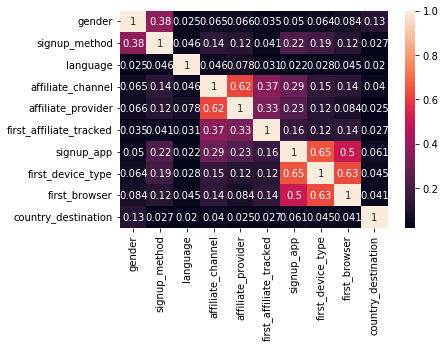

In [26]:
cat_attributes_users_columns = cat_attributes_users.drop('id', axis=1).columns.tolist()

corr_dict = {}

for main_column in cat_attributes_users_columns:
    corr_list = []
    
    for secondary_column in cat_attributes_users_columns:
        # cramer v
        cat_corr = cramer_v( cat_attributes_users[main_column], cat_attributes_users[secondary_column] )
        
        # add to list
        corr_list.append(cat_corr)
    
    # add to dict each attribute correlation 
    corr_dict[main_column] = corr_list

df_corr_users = pd.DataFrame(corr_dict)
df_corr_users = df_corr_users.set_index(df_corr_users.columns)
sns.heatmap(df_corr_users, annot=True);

### 1.7.4. Categorical - Data Sessions

In [27]:
cat_attributes_sessions.drop('user_id', axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


#### 1.7.4.1. Correlation Matrix

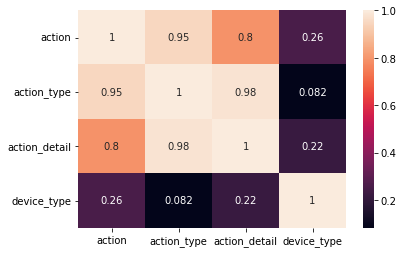

In [28]:
cat_attributes_sessions_columns = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()

corr_dict = {}

for main_column in cat_attributes_sessions_columns:
    corr_list = []
    
    for secondary_column in cat_attributes_sessions_columns:
        # cramer v
        cat_corr = cramer_v( cat_attributes_sessions[main_column], cat_attributes_sessions[secondary_column] )
        
        # add to list
        corr_list.append(cat_corr)
    
    # add to dict each attribute correlation 
    corr_dict[main_column] = corr_list

df_corr_sessions = pd.DataFrame(corr_dict)
df_corr_sessions = df_corr_sessions.set_index(df_corr_sessions.columns)
sns.heatmap(df_corr_sessions, annot=True);

# 2.0. Feature Engineering

In [29]:
df02_users = df01_users.copy()

## 2.1. Create Gap Between Dates Features

In [30]:
# date of first active
df02_users['date_first_active'] = pd.to_datetime(df02_users['timestamp_first_active'].dt.strftime("%Y-%m-%d"))

# difference in days between date_account_created and date_first_active
df02_users['diff_account_created_first_active'] = (df02_users['date_account_created'] - df02_users['date_first_active']).apply(lambda x: x.days)

# difference in days between date_account_created and date_first_booking
df02_users['diff_first_booking_account_created'] = (df02_users['date_first_booking'] - df02_users['date_account_created']).apply(lambda x: x.days)

# difference in days between date_first_active and date_first_booking
df02_users['diff_first_active_first_booking'] = (df02_users['date_first_booking'] - df02_users['date_first_active']).apply(lambda x: x.days)

## 2.2. Create Date Features

### 2.2.1. Account Created

In [31]:
# year
df02_users['year_account_created'] = df02_users['date_account_created'].dt.year

# month
df02_users['month_account_created'] = df02_users['date_account_created'].dt.month

# day
df02_users['day_account_created'] = df02_users['date_account_created'].dt.day

# day of week
df02_users['dayofweek_account_created'] = df02_users['date_account_created'].dt.dayofweek

# week of year
df02_users['weekofyear_account_created'] = df02_users['date_account_created'].dt.weekofyear

### 2.2.2. First Active

In [32]:
# year
df02_users['year_first_active'] = df02_users['date_first_active'].dt.year

# month
df02_users['month_first_active'] = df02_users['date_first_active'].dt.month

# day
df02_users['day_first_active'] = df02_users['date_first_active'].dt.day

# day of week
df02_users['dayofweek_first_active'] = df02_users['date_first_active'].dt.dayofweek

# week of year
df02_users['weekofyear_first_active'] = df02_users['date_first_active'].dt.weekofyear

### 2.2.3. First Booking

In [33]:
# year
df02_users['year_first_booking'] = df02_users['date_first_booking'].dt.year

# month
df02_users['month_first_booking'] = df02_users['date_first_booking'].dt.month

# day
df02_users['day_first_booking'] = df02_users['date_first_booking'].dt.day

# day of week
df02_users['dayofweek_first_booking'] = df02_users['date_first_booking'].dt.dayofweek

# week of year
df02_users['weekofyear_first_booking'] = df02_users['date_first_booking'].dt.weekofyear

# 3.0. Data Filtering

In [34]:
df03_users = df02_users.copy()

## 3.1. Filtering Rows

In [35]:
# age - greater than 15 and lower than 100 - There are few people over 100 years old ( Could be error from system or manual imput - Cleaning noise)
df03_users = df03_users[(df03_users['age'] > 15) & (df03_users['age'] < 100)]

# secs_elapsed - there is no possible 0 secs elapesed on website
#df03_sessions = df03_sessions[df03_sessions['secs_elapsed'] > 0]

## 3.2. Columns Selection

In [36]:
# columns id not carry any information
df03_users = df03_users.drop(['id'], axis=1)

# columns used to feature enginnering
cols_date =['timestamp_first_active',
            'date_first_active',
            'date_account_created',
            'date_first_booking']

df03_users = df03_users.drop(columns=cols_date)

# 4.0. Data Exploratory Analysis

To increase time, the EDA stage will be skipped in this first cycle.

In [37]:
df04_users = df03_users.copy()

# 5.0. Data Preparation

In [38]:
df05_users = df04_users.copy()

## 5.1. Encoding

In [39]:
# dummy variable
df05_users_dummy = pd.get_dummies(df05_users.drop(['country_destination'], axis=1))

# join id and country destination
df05_users = pd.concat( [df05_users['country_destination'], df05_users_dummy], axis=1 )

## 5.2. Response Variable

In [40]:
# create OneHotEncoder instance
ohe = pp.OneHotEncoder()

# ohe hot encoding response feature
df_ohe = pd.DataFrame(ohe.fit_transform(df05_users['country_destination'].values.reshape(-1,1)).toarray(),
                      columns=ohe.categories_[0],
                      index=df05_users.index)

# joining encoded response feature to dataset
df05_users = pd.concat([df05_users.drop(columns=['country_destination']), df_ohe], axis=1)

## 5.3. Balance Dataset

### 5.3.1. Random Undersampling

In [59]:
# define sampler - random under-sampling
undersampling = us.RandomUnderSampler(sampling_strategy='not minority', random_state=32)

# resample the dataset
X_under, y_under = undersampling.fit_resample(df05_users.drop(columns=ohe.categories_[0]), 
                                              ohe.inverse_transform(df05_users[ohe.categories_[0]]))

In [60]:
pd.DataFrame(ohe.inverse_transform(df05_users[ohe.categories_[0]])).value_counts()

NDF      119187
US        60129
other      9816
FR         4840
IT         2742
GB         2259
ES         2183
CA         1369
DE         1024
NL          739
AU          519
PT          212
dtype: int64

In [61]:
pd.DataFrame(y_under).value_counts()

AU       212
CA       212
DE       212
ES       212
FR       212
GB       212
IT       212
NDF      212
NL       212
PT       212
US       212
other    212
dtype: int64

In [62]:
# convert back to encoding representation
y_under = pd.DataFrame(ohe.transform(y_under.reshape(-1,1)).toarray(),
                       columns=ohe.categories_[0],
                       index=X_under.index)

# join dataset
df05_users_under = pd.concat([X_under, y_under], axis=1)

### 5.3.2. Random Oversampling

In [48]:
# define sampler - random over-sampling
oversampling = osamp.RandomOverSampler(sampling_strategy='not majority', random_state=32)

# resample the dataset
X_over, y_over = oversampling.fit_resample(df05_users.drop(columns=ohe.categories_[0]), 
                                           ohe.inverse_transform(df05_users[ohe.categories_[0]]))

In [49]:
pd.DataFrame(ohe.inverse_transform(df05_users[ohe.categories_[0]])).value_counts()

NDF      119187
US        60129
other      9816
FR         4840
IT         2742
GB         2259
ES         2183
CA         1369
DE         1024
NL          739
AU          519
PT          212
dtype: int64

In [50]:
pd.DataFrame(y_over).value_counts()

AU       119187
CA       119187
DE       119187
ES       119187
FR       119187
GB       119187
IT       119187
NDF      119187
NL       119187
PT       119187
US       119187
other    119187
dtype: int64

In [51]:
# convert back to encodign representation
y_over = pd.DataFrame(ohe.transform(y_over.reshape(-1,1)).toarray(), 
                      columns=ohe.categories_[0], 
                      index=X_over.index)

# join dataset
df05_users_over = pd.concat([X_over, y_over], axis=1)

### 5.3.3. SMOTE + TOMEKLINK

In [52]:
# define sample - over-sampling using SMOTE and cleaning using Tomek Links
combine = comb.SMOTETomek(sampling_strategy='auto', random_state=32, n_jobs=-1)

# resample the dataset
X_comb, y_comb = combine.fit_resample(df05_users.drop(columns=ohe.categories_[0]), 
                                      ohe.inverse_transform(df05_users[ohe.categories_[0]]))

In [53]:
pd.DataFrame(ohe.inverse_transform(df05_users[ohe.categories_[0]])).value_counts()

NDF      119187
US        60129
other      9816
FR         4840
IT         2742
GB         2259
ES         2183
CA         1369
DE         1024
NL          739
AU          519
PT          212
dtype: int64

In [54]:
pd.DataFrame(y_comb).value_counts()

NDF      119186
PT       119178
AU       119169
NL       119144
DE       119134
CA       119098
ES       119075
GB       119065
IT       119021
FR       118828
other    118428
US       117914
dtype: int64

In [55]:
# convert back to encoding representation
y_comb = pd.DataFrame(ohe.transform(y_comb.reshape(-1,1)).toarray(), 
                      columns=ohe.categories_[0], 
                      index=X_comb.index)

# join dataset
df05_users_comb = pd.concat([X_comb, y_comb], axis=1)

# 6.0. Feature Selection

In [63]:
df06_users = df05_users.copy()

df06_users_under = df05_users_under.copy()
df06_users_over = df05_users_over.copy()
df06_users_comb = df05_users_comb.copy()

## 6.1. Split Dataframe into Training and Test Dataset

In [64]:
# training dataset
X = df06_users.drop( columns=ohe.categories_[0] )
X_under = df06_users_under.drop( columns=ohe.categories_[0] )
X_over = df06_users_over.drop( columns=ohe.categories_[0] )
X_comb = df06_users_comb.drop( columns=ohe.categories_[0] )

#  training response dataset
y = df06_users[ohe.categories_[0]]
y_under = df06_users_under[ohe.categories_[0]]
y_over = df06_users_over[ohe.categories_[0]]
y_comb = df06_users_comb[ohe.categories_[0]]

In [65]:
# Split dataset into training and test (validation)
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

X_train_under, X_test_under, y_train_under, y_test_under = ms.train_test_split(X_under, y_under, test_size=0.2, random_state=32)

X_train_over, X_test_over, y_train_over, y_test_over = ms.train_test_split(X_over, y_over, test_size=0.2, random_state=32)

X_train_comb, X_test_comb, y_train_comb, y_test_comb = ms.train_test_split(X_comb, y_comb, test_size=0.2, random_state=32)

## 6.2. Balanced Dataset

### 6.2.1. Random Undersampling

In [ ]:
# # define sampler - random under-sampling
# undersampling = us.RandomUnderSampler(sampling_strategy='not minority', random_state=32)

# # resample the dataset
# X_train_under, y_train_under = undersampling.fit_resample(X_train, ohe.inverse_transform(y_train))

In [ ]:
# pd.DataFrame(ohe.inverse_transform(y_train)).value_counts()

In [ ]:
# pd.DataFrame(y_train_under).value_counts()

In [ ]:
# # convert back to encoding representation
# y_train_under = pd.DataFrame(ohe.transform(y_train_under.reshape(-1,1)).toarray(), 
#                              columns=ohe.categories_[0], 
#                              index=X_train_under.index)

### 6.2.2. Random Oversampling

In [ ]:
# # define sampler - random over-sampling
# oversampling = osamp.RandomOverSampler(sampling_strategy='not majority', random_state=32)

# # resample the dataset
# X_train_over, y_train_over = oversampling.fit_resample(X_train, ohe.inverse_transform(y_train))

In [ ]:
# pd.DataFrame(ohe.inverse_transform(y_train)).value_counts()

In [ ]:
# pd.DataFrame(y_train_over).value_counts()

In [ ]:
# # convert back to encoding representation
# y_train_over = pd.DataFrame(ohe.transform(y_train_over.reshape(-1,1)).toarray(), 
#                             columns=ohe.categories_[0], 
#                             index=X_train_over.index)

### 6.2.3. SMOTE + TOMEKLINK

In [ ]:
# # define sampler - over-sampling using SMOTE and cleaning using Tomek links
# combine = comb.SMOTETomek(sampling_strategy='auto', random_state=32, n_jobs=-1)

# # resample the dataset
# X_train_comb, y_train_comb = combine.fit_resample(X_train, ohe.inverse_transform(y_train))

In [ ]:
# pd.DataFrame(ohe.inverse_transform(y_train)).value_counts()

In [ ]:
# pd.DataFrame(y_train_comb).value_counts()

In [ ]:
# # convert back to encoding representation
# y_train_comb = pd.DataFrame(ohe.transform(y_train_comb.reshape(-1,1)).toarray(), 
#                             columns=ohe.categories_[0], 
#                             index=X_train_comb.index)

# 7.0. Machine Learing Model

In [66]:
# imbalanced dataset
x_train = X_train
x_test = X_test

# random undersampling
x_train_under = X_train_under
x_test_under = X_test_under

# random oversampling
x_train_over = X_train_over
x_test_over = X_test_over

# SMOTE + Tomek Links
x_train_comb = X_train_comb
x_test_comb = X_test_comb

## 7.1. Baseline Model - Random

In [67]:
# list of country destination
country_list = ohe.categories_[0].tolist()

# number of rows
k_num = y_test.shape[0]

# proportion of country destinations for imbalanced result
df_ohe = pd.DataFrame(ohe.inverse_transform(df06_users[ohe.categories_[0]]))
country_weights = df_ohe.value_counts(normalize=True).sort_index().tolist()

# prediction
yhat_random = random.choices(population=country_list,
                             weights=country_weights,
                             k=k_num)

# invert validation response
y_test_random = ohe.inverse_transform(y_test)

### 7.1.1. Baseline Model - Performance

Accuracy 0.42893376255975024
Balanced Accuracy: 0.0846614183431877
Kappa Score: 0.005919577825187261
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        98
          CA       0.01      0.01      0.01       283
          DE       0.01      0.01      0.01       227
          ES       0.01      0.01      0.01       433
          FR       0.03      0.03      0.03       963
          GB       0.01      0.01      0.01       469
          IT       0.02      0.02      0.02       539
         NDF       0.58      0.59      0.58     23643
          NL       0.01      0.01      0.01       156
          PT       0.00      0.00      0.00        36
          US       0.30      0.29      0.30     12192
       other       0.05      0.05      0.05      1965

    accuracy                           0.43     41004
   macro avg       0.08      0.08      0.08     41004
weighted avg       0.43      0.43      0.43     41004



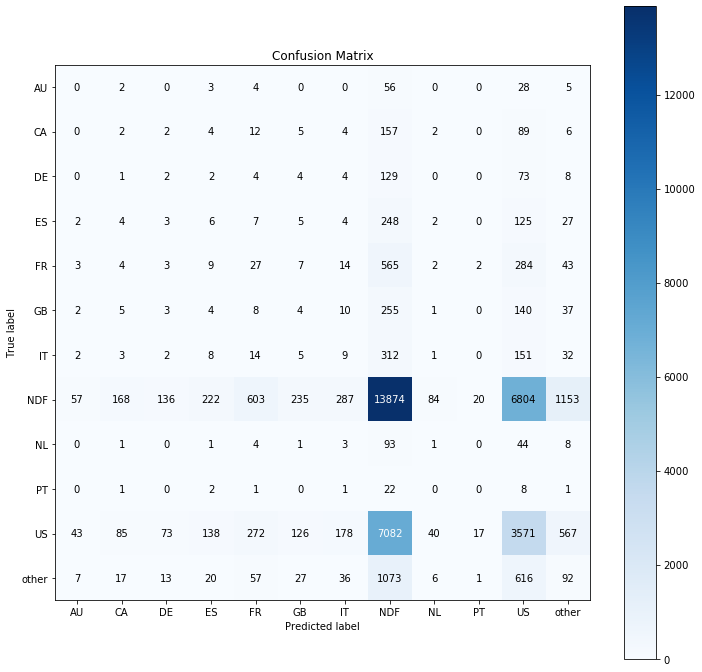

In [68]:
# Accuracy
acc_random = m.accuracy_score( y_test_random, yhat_random )
print(f'Accuracy {acc_random}')

# Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test_random, yhat_random)
print(f'Balanced Accuracy: {balanced_acc_random}')

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test_random, yhat_random)
print(f'Kappa Score: {kappa_random}')

# Classification report
print(m.classification_report(y_test_random, yhat_random))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_random, yhat_random, normalize=False, figsize=(12,12));

# Performance
baseline_performance = {'model': 'Baseline Model',
                        'acc': acc_random,
                        'balanced_acc': balanced_acc_random,
                        'kappa_store': kappa_random}

## 7.2. Neural Network - MLP

### 7.2.1. Imbalanced Data

In [69]:
# model definition
model_nn = ml.Sequential()
model_nn.add( l.Dense(128, input_dim=x_train.shape[1], activation='relu') )
model_nn.add( l.Dense(12, activation='softmax') )

# model compile
model_nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model_nn.fit(x_train, y_train, epochs=100)

Epoch 1/100
5126/5126 [==============================] - 7s 1ms/step - loss: 3.4670 - accuracy: 0.8023
Epoch 2/100
5126/5126 [==============================] - 7s 1ms/step - loss: 1.2658 - accuracy: 0.8208: 0s - loss: 1.292
Epoch 3/100
5126/5126 [==============================] - 7s 1ms/step - loss: 0.8217 - accuracy: 0.8402
Epoch 4/100
5126/5126 [==============================] - 6s 1ms/step - loss: 0.5962 - accuracy: 0.8606
Epoch 5/100
5126/5126 [==============================] - 7s 1ms/step - loss: 0.5147 - accuracy: 0.8723
Epoch 6/100
5126/5126 [==============================] - 7s 1ms/step - loss: 0.4990 - accuracy: 0.8732
Epoch 7/100
5126/5126 [==============================] - 7s 1ms/step - loss: 0.4977 - accuracy: 0.8738
Epoch 8/100
5126/5126 [==============================] - 6s 1ms/step - loss: 0.4942 - accuracy: 0.8741
Epoch 9/100
5126/5126 [==============================] - 6s 1ms/step - loss: 0.4943 - accuracy: 0.8741
Epoch 10/100
5126/5126 [==============================]

#### 7.2.1.1. Imbalanced Data - Perfomance

In [70]:
# prediction
pred_nn = model_nn.predict(x_test)

# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# invert validation response
y_test_nn = ohe.inverse_transform(y_test)

In [71]:
# check the balance of validation
pd.DataFrame(y_test_nn).value_counts(normalize=True)

NDF      0.576602
US       0.297337
other    0.047922
FR       0.023486
IT       0.013145
GB       0.011438
ES       0.010560
CA       0.006902
DE       0.005536
NL       0.003805
AU       0.002390
PT       0.000878
dtype: float64

In [72]:
# check the balance of result
pd.DataFrame(yhat_nn).value_counts(normalize=True)

NDF    0.576627
US     0.423373
dtype: float64

Accuracy: 0.8739147400253634
Balanced Accuracy: 0.16665983158355205
Kappa Score: 0.7672119939094182
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        98
          CA       0.00      0.00      0.00       283
          DE       0.00      0.00      0.00       227
          ES       0.00      0.00      0.00       433
          FR       0.00      0.00      0.00       963
          GB       0.00      0.00      0.00       469
          IT       0.00      0.00      0.00       539
         NDF       1.00      1.00      1.00     23643
          NL       0.00      0.00      0.00       156
          PT       0.00      0.00      0.00        36
          US       0.70      1.00      0.83     12192
       other       0.00      0.00      0.00      1965

    accuracy                           0.87     41004
   macro avg       0.14      0.17      0.15     41004
weighted avg       0.79      0.87      0.82     41004



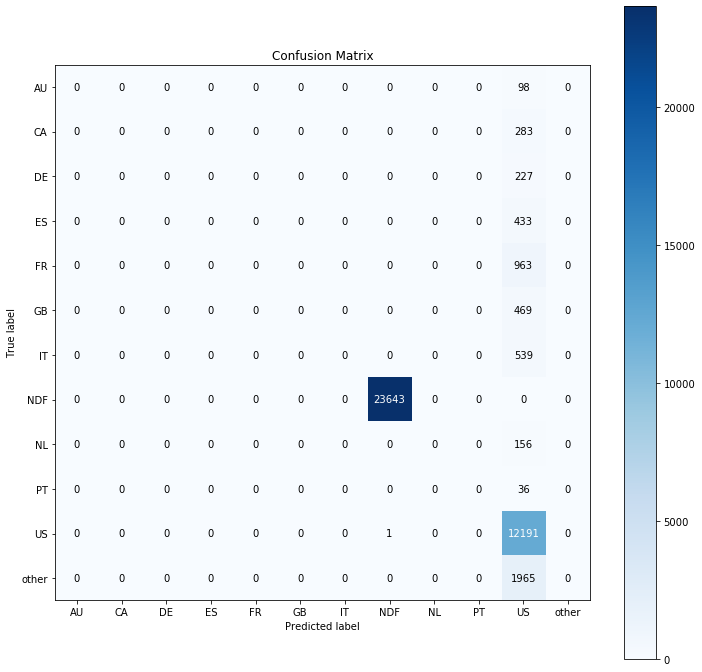

In [73]:
# Accuracy
acc_nn = m.accuracy_score( y_test_nn, yhat_nn )
print(f'Accuracy: {acc_nn}')

# Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print(f'Balanced Accuracy: {balanced_acc_nn}')

# Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print(f'Kappa Score: {kappa_nn}')

# Classification report
print(m.classification_report(y_test_nn, yhat_nn))

# Confusion Matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False, figsize=(12,12));

# Performance
imb_performance = {'model': 'NN Model - Imbalanced Data', 
                   'acc': np.round(acc_nn, 6), 
                   'balanced_acc': np.round(balanced_acc_nn, 6), 
                   'kappa_score': np.round(kappa_nn, 6)}

#### 7.2.1.2. Imbalanced Data - Cross-Validation

In [92]:
# cross validation performance
acc_nn, balanced_acc_nn, kappa_nn = cross_validation(num_fold=5, 
                                                     x_train=x_train, 
                                                     y_train=y_train, 
                                                     model=model_nn, 
                                                     verbose=True)

Fold Number:1/5
Fold Number:2/5
Fold Number:3/5
Fold Number:4/5
Fold Number:5/5


In [93]:
# Performance
imb_performance_cv = {'model': 'NN Model - Imbalanced Data - CV',
                        'acc': f'{np.round(np.mean(acc_nn), 2)} +/- {np.round(np.std(acc_nn), 4)}',
                        'balanced_acc': f'{np.round(np.mean(balanced_acc_nn), 2)} +/- {np.round(np.std(balanced_acc_nn), 4)}',
                        'kappa_score': f'{np.round(np.mean(kappa_nn), 2)} +/- {np.round(np.std(kappa_nn), 4)}'}

In [94]:
print(f'Avg Accuracy: {np.round(np.mean(acc_nn), 2)} +/- {np.round(np.std(acc_nn),5)}')
print(f'Avg Balanced Accuracy: {np.round(np.mean(balanced_acc_nn), 2)} +/- {np.round(np.std(balanced_acc_nn),5)}')
print(f'Avg Kappa Score: {np.round(np.mean(kappa_nn), 2)} +/- {np.round(np.std(kappa_nn), 4)}')

Avg Accuracy: 0.87 +/- 3e-05
Avg Balanced Accuracy: 0.17 +/- 1e-05
Avg Kappa Score: 0.77 +/- 0.0001


### 7.2.2. Neural Network - Random Undersampling

In [74]:
# model definition
model_under = ml.Sequential()
model_under.add( l.Dense(128, input_dim=x_train_under.shape[1], activation='relu') )
model_under.add( l.Dense(12, activation='softmax') )

# model compile
model_under.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model_under.fit(x_train_under, y_train_under, epochs=100)

Epoch 1/100
64/64 [==============================] - 0s 1ms/step - loss: 98.3961 - accuracy: 0.1425
Epoch 2/100
64/64 [==============================] - 0s 2ms/step - loss: 8.9833 - accuracy: 0.1730
Epoch 3/100
64/64 [==============================] - 0s 6ms/step - loss: 7.0128 - accuracy: 0.1735: 0s - loss: 8.1704 - accura
Epoch 4/100
64/64 [==============================] - 0s 4ms/step - loss: 7.7028 - accuracy: 0.1690
Epoch 5/100
64/64 [==============================] - 0s 2ms/step - loss: 9.7772 - accuracy: 0.1597
Epoch 6/100
64/64 [==============================] - 0s 1ms/step - loss: 6.9671 - accuracy: 0.1661
Epoch 7/100
64/64 [==============================] - 0s 1ms/step - loss: 9.6437 - accuracy: 0.1617
Epoch 8/100
64/64 [==============================] - 0s 1ms/step - loss: 6.1327 - accuracy: 0.1749
Epoch 9/100
64/64 [==============================] - 0s 2ms/step - loss: 7.6518 - accuracy: 0.1700
Epoch 10/100
64/64 [==============================] - 0s 2ms/step - loss: 7.7232

#### 7.2.2.1. Random Undersampling - Performance

In [75]:
# prediction
pred_under_nn = model_under.predict(x_test_under)

# invert prediction
yhat_under_nn = ohe.inverse_transform(pred_under_nn)

# invert validation response
y_test_under_nn = ohe.inverse_transform(y_test_under)

In [76]:
# check the balance of validation
pd.DataFrame(y_test_under_nn).value_counts(normalize=True)

IT       0.096267
ES       0.090373
DE       0.088409
GB       0.088409
NL       0.086444
PT       0.086444
AU       0.082515
CA       0.082515
FR       0.078585
other    0.074656
NDF      0.072692
US       0.072692
dtype: float64

In [77]:
# check the balance of results
pd.DataFrame(yhat_under_nn).value_counts(normalize=True)

GB     0.499018
PT     0.422397
NDF    0.070727
US     0.005894
AU     0.001965
dtype: float64

Accuracy: 0.15913555992141454
Balanced Accuracy: 0.1656986531986532
Kappa Score: 0.07965155086901043
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        42
          CA       0.00      0.00      0.00        42
          DE       0.00      0.00      0.00        45
          ES       0.00      0.00      0.00        46
          FR       0.00      0.00      0.00        40
          GB       0.09      0.51      0.15        45
          IT       0.00      0.00      0.00        49
         NDF       1.00      0.97      0.99        37
          NL       0.00      0.00      0.00        44
          PT       0.10      0.48      0.16        44
          US       0.33      0.03      0.05        37
       other       0.00      0.00      0.00        38

    accuracy                           0.16       509
   macro avg       0.13      0.17      0.11       509
weighted avg       0.11      0.16      0.10       509



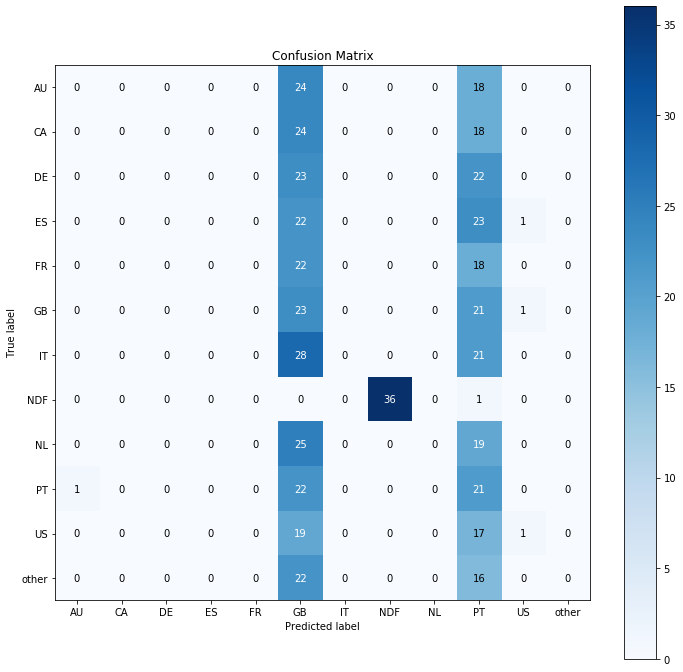

In [78]:
# Accuracy
acc_under_nn = m.accuracy_score( y_test_under_nn, yhat_under_nn )
print(f'Accuracy: {acc_under_nn}')

# Balanced Accuracy
balanced_acc_under_nn = m.balanced_accuracy_score(y_test_under_nn, yhat_under_nn)
print(f'Balanced Accuracy: {balanced_acc_under_nn}')

# Kappa Metrics
kappa_under_nn = m.cohen_kappa_score(y_test_under_nn, yhat_under_nn)
print(f'Kappa Score: {kappa_under_nn}')

# Classification report
print(m.classification_report(y_test_under_nn, yhat_under_nn))

# Confusion Matrix
mt.plot_confusion_matrix( y_test_under_nn, yhat_under_nn, normalize=False, figsize=(12,12));

# Performance
under_performance = {'model': 'NN Model - Random Undersampling', 
                     'acc': np.round(acc_under_nn, 6), 
                     'balanced_acc': np.round(balanced_acc_under_nn, 6), 
                     'kappa_score': np.round(kappa_under_nn, 6)}

#### 7.2.2.2. Random Undersampling - Cross-Validation

In [79]:
# cross validation performance
acc_under, balanced_acc_under, kappa_under = cross_validation(num_fold=5, 
                                                              x_train=x_train_under, 
                                                              y_train=y_train_under, 
                                                              model=model_under, 
                                                              verbose=True)

Fold Number:1/5
Fold Number:2/5
Fold Number:3/5
Fold Number:4/5
Fold Number:5/5


In [80]:
# Performance
under_performance_cv = {'model': 'NN Model - Random Undersampling - CV',
                        'acc': f'{np.round(np.mean(acc_under), 2)} +/- {np.round(np.std(acc_under), 4)}',
                        'balanced_acc': f'{np.round(np.mean(balanced_acc_under), 2)} +/- {np.round(np.std(balanced_acc_under), 4)}',
                        'kappa_score': f'{np.round(np.mean(kappa_under), 2)} +/- {np.round(np.std(kappa_under), 4)}'}

In [81]:
print(f'Avg Accuracy: {np.round(np.mean(acc_under), 2)} +/- {np.round(np.std(acc_under),5)}')
print(f'Avg Balanced Accuracy: {np.round(np.mean(balanced_acc_under), 2)} +/- {np.round(np.std(balanced_acc_under),5)}')
print(f'Avg Kappa Score: {np.round(np.mean(kappa_under), 2)} +/- {np.round(np.std(kappa_under), 4)}')

Avg Accuracy: 0.17 +/- 0.00241
Avg Balanced Accuracy: 0.17 +/- 0.00357
Avg Kappa Score: 0.1 +/- 0.0037


### 7.2.3. Random Oversampling 

In [82]:
# model definition
model_over = ml.Sequential()
model_over.add( l.Dense(128, input_dim=x_train_over.shape[1], activation='relu') )
model_over.add( l.Dense(12, activation='softmax') )

# model compile
model_over.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model_over.fit(x_train_over, y_train_over, epochs=100)

Epoch 1/100
35757/35757 [==============================] - 58s 2ms/step - loss: 3.3698 - accuracy: 0.1725 0s - loss: 3.3727 - accuracy: 
Epoch 2/100
35757/35757 [==============================] - 51s 1ms/step - loss: 2.2010 - accuracy: 0.1664
Epoch 3/100
35757/35757 [==============================] - 52s 1ms/step - loss: 2.1998 - accuracy: 0.1675
Epoch 4/100
35757/35757 [==============================] - 54s 2ms/step - loss: 2.1995 - accuracy: 0.1670 1s - loss: 2.1995 - accuracy:  - ETA: 1s - loss: 2.1995 - ac - ETA: 1s - loss: 2.1995 - accuracy
Epoch 5/100
35757/35757 [==============================] - 54s 2ms/step - loss: 2.1994 - accuracy: 0.1671
Epoch 6/100
35757/35757 [==============================] - 51s 1ms/step - loss: 2.1992 - accuracy: 0.1668 0s - loss: 2.1
Epoch 7/100
35757/35757 [==============================] - 55s 2ms/step - loss: 2.1991 - accuracy: 0.1673
Epoch 8/100
35757/35757 [==============================] - 53s 1ms/step - loss: 2.1990 - accuracy: 0.1677
Epoch 9/1

#### 7.2.3.1. Random Oversampling - Performance

In [83]:
# prediction
pred_over_nn = model_over.predict(x_test_over)

# invert prediction
yhat_over_nn = ohe.inverse_transform(pred_over_nn)

# invert validation response
y_test_over_nn = ohe.inverse_transform(y_test_over)

In [84]:
# check the balance of validation
pd.DataFrame(y_test_over_nn).value_counts(normalize=True)

CA       0.084056
NL       0.083702
ES       0.083688
US       0.083678
DE       0.083507
NDF      0.083353
IT       0.083192
AU       0.083094
other    0.083059
FR       0.082926
PT       0.082909
GB       0.082835
dtype: float64

In [85]:
# check balanced results
pd.DataFrame(yhat_over_nn).value_counts(normalize=True)

AU     0.914266
NDF    0.082860
PT     0.002321
CA     0.000542
IT     0.000007
DE     0.000003
dtype: float64

Accuracy: 0.16651692542186827
Balanced Accuracy: 0.16674021328965924
Kappa Score: 0.09096157516393055
              precision    recall  f1-score   support

          AU       0.09      1.00      0.17     23769
          CA       0.00      0.00      0.00     24044
          DE       0.00      0.00      0.00     23887
          ES       0.00      0.00      0.00     23939
          FR       0.00      0.00      0.00     23721
          GB       0.00      0.00      0.00     23695
          IT       0.00      0.00      0.00     23797
         NDF       1.00      0.99      1.00     23843
          NL       0.00      0.00      0.00     23943
          PT       0.33      0.01      0.02     23716
          US       0.00      0.00      0.00     23936
       other       0.00      0.00      0.00     23759

    accuracy                           0.17    286049
   macro avg       0.12      0.17      0.10    286049
weighted avg       0.12      0.17      0.10    286049



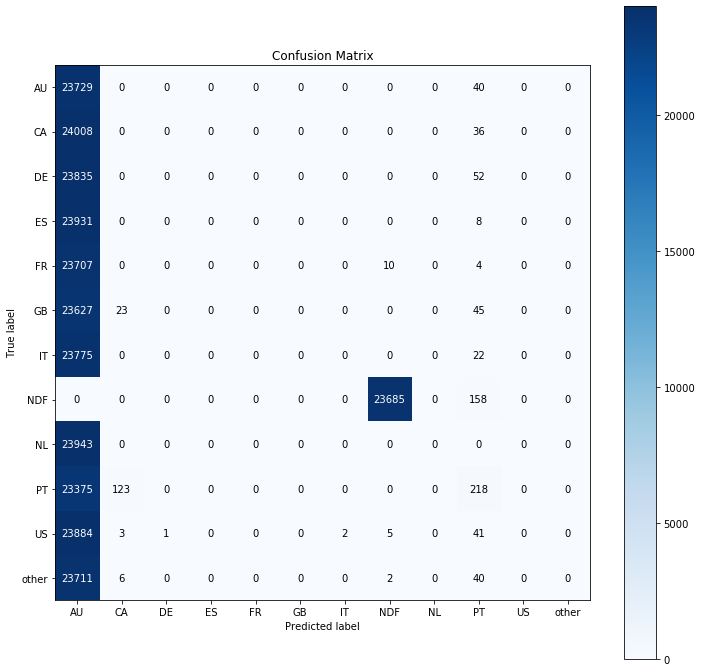

In [86]:
# Accuracy
acc_over_nn = m.accuracy_score( y_test_over_nn, yhat_over_nn )
print(f'Accuracy: {acc_over_nn}')

# Balanced Accuracy
balanced_acc_over_nn = m.balanced_accuracy_score(y_test_over_nn, yhat_over_nn)
print(f'Balanced Accuracy: {balanced_acc_over_nn}')

# Kappa Metrics
kappa_over_nn = m.cohen_kappa_score(y_test_over_nn, yhat_over_nn)
print(f'Kappa Score: {kappa_over_nn}')

# Classification report
print(m.classification_report(y_test_over_nn, yhat_over_nn))

# Confusion Matrix
mt.plot_confusion_matrix( y_test_over_nn, yhat_over_nn, normalize=False, figsize=(12,12));

# Performance
over_performance = {'model': 'NN Model - Random Oversampling', 
                    'acc': np.round(acc_over_nn, 6), 
                    'balanced_acc': np.round(balanced_acc_over_nn, 6), 
                    'kappa_score': np.round(kappa_over_nn, 6)}

#### 7.2.3.2. Random Oversampling - Cross-Validation

In [95]:
# cross validation performance
acc_over, balanced_acc_over, kappa_over = cross_validation(num_fold=5, 
                                                           x_train=x_train_over, 
                                                           y_train=y_train_over, 
                                                           model=model_over, 
                                                           verbose=True)

Fold Number:1/5
Fold Number:2/5
Fold Number:3/5
Fold Number:4/5
Fold Number:5/5


In [96]:
# Performance
over_performance_cv = {'model': 'NN Model - Random Oversampling - CV',
                        'acc': f'{np.round(np.mean(acc_over), 2)} +/- {np.round(np.std(acc_over), 4)}',
                        'balanced_acc': f'{np.round(np.mean(balanced_acc_over), 2)} +/- {np.round(np.std(balanced_acc_over), 4)}',
                        'kappa_score': f'{np.round(np.mean(kappa_over), 2)} +/- {np.round(np.std(kappa_over), 4)}'}

In [97]:
print(f'Avg Accuracy: {np.round(np.mean(acc_over), 2)} +/- {np.round(np.std(acc_over),5)}')
print(f'Avg Balanced Accuracy: {np.round(np.mean(balanced_acc_over), 2)} +/- {np.round(np.std(balanced_acc_over),5)}')
print(f'Avg Kappa Score: {np.round(np.mean(kappa_over), 2)} +/- {np.round(np.std(kappa_over), 4)}')

Avg Accuracy: 0.17 +/- 0.00083
Avg Balanced Accuracy: 0.17 +/- 0.00086
Avg Kappa Score: 0.09 +/- 0.0009


### 7.2.4. Neural Network - SMOTE + TOMEKLINK

In [87]:
# model definition
model_comb = ml.Sequential()
model_comb.add( l.Dense(128, input_dim=x_train_comb.shape[1], activation='relu') )
model_comb.add( l.Dense(12, activation='softmax') )

# model compile
model_comb.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model_comb.fit(x_train_comb, y_train_comb, epochs=100)

Epoch 1/100
35681/35681 [==============================] - 33s 916us/step - loss: 3.3467 - accuracy: 0.1981
Epoch 2/100
35681/35681 [==============================] - 33s 920us/step - loss: 2.1488 - accuracy: 0.2074
Epoch 3/100
35681/35681 [==============================] - 34s 951us/step - loss: 2.1422 - accuracy: 0.2082
Epoch 4/100
35681/35681 [==============================] - 33s 934us/step - loss: 2.1404 - accuracy: 0.2086
Epoch 5/100
35681/35681 [==============================] - 33s 926us/step - loss: 2.1391 - accuracy: 0.2095
Epoch 6/100
35681/35681 [==============================] - 34s 964us/step - loss: 2.1382 - accuracy: 0.2101
Epoch 7/100
35681/35681 [==============================] - 35s 979us/step - loss: 2.1372 - accuracy: 0.2108
Epoch 8/100
35681/35681 [==============================] - 34s 943us/step - loss: 2.1369 - accuracy: 0.2109
Epoch 9/100
35681/35681 [==============================] - 33s 934us/step - loss: 2.1362 - accuracy: 0.2110
Epoch 10/100
35681/35681 [==

#### 7.2.4.1. SMOTE + TOMEKLINK - Performance

In [88]:
# prediction
pred_comb_nn = model_comb.predict(x_test_comb)

# invert prediction
yhat_comb_nn = ohe.inverse_transform(pred_comb_nn)

# invert validation response
y_test_comb_nn = ohe.inverse_transform(y_test_comb)

In [89]:
# check the balance of validation
pd.DataFrame(y_test_comb_nn).value_counts(normalize=True)

NL       0.084506
CA       0.084078
IT       0.083612
ES       0.083465
AU       0.083458
DE       0.083231
FR       0.083087
NDF      0.083087
GB       0.083006
other    0.082961
PT       0.082842
US       0.082667
dtype: float64

In [90]:
# check the balance of result
pd.DataFrame(yhat_comb_nn).value_counts(normalize=True)

PT       0.472086
other    0.223694
US       0.196799
NDF      0.083125
CA       0.024295
dtype: float64

Accuracy: 0.21757027549676297
Balanced Accuracy: 0.21866692377245867
Kappa Score: 0.14685820638473157
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00     23823
          CA       0.09      0.02      0.04     24000
          DE       0.00      0.00      0.00     23758
          ES       0.00      0.00      0.00     23825
          FR       0.00      0.00      0.00     23717
          GB       0.00      0.00      0.00     23694
          IT       0.00      0.00      0.00     23867
         NDF       1.00      1.00      1.00     23717
          NL       0.00      0.00      0.00     24122
          PT       0.12      0.68      0.20     23647
          US       0.27      0.65      0.39     23597
       other       0.10      0.27      0.15     23681

    accuracy                           0.22    285448
   macro avg       0.13      0.22      0.15    285448
weighted avg       0.13      0.22      0.15    285448



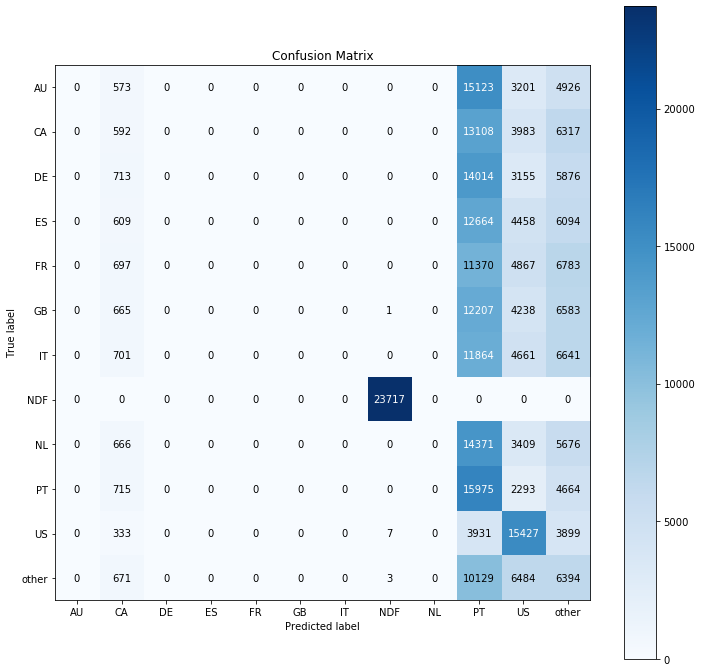

In [91]:
# Accuracy
acc_comb_nn = m.accuracy_score( y_test_comb_nn, yhat_comb_nn )
print(f'Accuracy: {acc_comb_nn}')

# Balanced Accuracy
balanced_acc_comb_nn = m.balanced_accuracy_score(y_test_comb_nn, yhat_comb_nn)
print(f'Balanced Accuracy: {balanced_acc_comb_nn}')

# Kappa Metrics
kappa_comb_nn = m.cohen_kappa_score(y_test_comb_nn, yhat_comb_nn)
print(f'Kappa Score: {kappa_comb_nn}')

# Classification report
print(m.classification_report(y_test_comb_nn, yhat_comb_nn))

# Confusion Matrix
mt.plot_confusion_matrix( y_test_comb_nn, yhat_comb_nn, normalize=False, figsize=(12,12));

# Performance
comb_performance = {'model': 'NN Model - SMOTE + TOMEKLINK', 
                    'acc': np.round(acc_comb_nn, 6), 
                    'balanced_acc': np.round(balanced_acc_comb_nn, 6), 
                    'kappa_score': np.round(kappa_comb_nn, 6)}

#### 7.2.4.2. SMOTE + TOMEKLINK - Cross-Validation

In [98]:
# cross validation performance
acc_comb, balanced_acc_comb, kappa_comb = cross_validation(num_fold=5, 
                                                           x_train=x_train_comb, 
                                                           y_train=y_train_comb, 
                                                           model=model_comb, 
                                                           verbose=True)

Fold Number:1/5
Fold Number:2/5
Fold Number:3/5
Fold Number:4/5
Fold Number:5/5


In [99]:
# Performance
comb_performance_cv = {'model': 'NN Model - SMOTE + TOMEKLINK - CV',
                       'acc': f'{np.round(np.mean(acc_comb), 2)} +/- {np.round(np.std(acc_comb), 4)}',
                       'balanced_acc': f'{np.round(np.mean(balanced_acc_comb), 2)} +/- {np.round(np.std(balanced_acc_comb), 4)}',
                       'kappa_score': f'{np.round(np.mean(kappa_comb), 2)} +/- {np.round(np.std(kappa_comb), 4)}'}

In [100]:
print(f'Avg Accuracy: {np.round(np.mean(acc_comb), 2)} +/- {np.round(np.std(acc_comb),5)}')
print(f'Avg Balanced Accuracy: {np.round(np.mean(balanced_acc_comb), 2)} +/- {np.round(np.std(balanced_acc_comb),5)}')
print(f'Avg Kappa Score: {np.round(np.mean(kappa_comb), 2)} +/- {np.round(np.std(kappa_comb), 4)}')

Avg Accuracy: 0.22 +/- 0.00403
Avg Balanced Accuracy: 0.22 +/- 0.00398
Avg Kappa Score: 0.15 +/- 0.0044


# 8.0. Hyper Parameter Tuning

Hyper Parameter Tuning will not be considered until the most optimal machine learning model is selected, at this first cycle was considered only one model to complete the cycle and go through for all the major phases to validate the feasibility of the project.

# 9.0. Error Translation and Interpretation

# 10.0. Deploy Model

No models will be deployed yet.

# 11.0. Conclusion

The use of 3 mechanisms to obtain a balanced distribution of classes was considered, including Random Undersampling, Random Oversampling and a synthetic sampling with data generation (SMOTE + Tomek Links).

The last of them was the only one to present any gain of performance, increasing the balanced accuracy to 0.22, 30% more than the previous cycle.

All balanced datasets showed similar results of Kappa Score, presenting a drop of 80% (0.77 to 0.15) in the oversamping mechanisms.

Another difference observed was in the distribution of classes in the prediction data, with a greater plurality, previously concentrated between the two marjority classes (NDF and US).

All the mechanisms will be maintained until the data preparation phase to evaluate the impact on results and verify if the Smote Tomek Links mechanism will continue with the best model's performance metrics.

## 11.1. Current Cycle Performance

In [101]:
# performance dataframe
df_performance = pd.DataFrame([baseline_performance, imb_performance, imb_performance_cv, 
                               under_performance, under_performance_cv, 
                               over_performance, over_performance_cv, 
                               comb_performance, comb_performance_cv])

df_performance['cycle'] = '5th_cycle'
df_performance['process'] = 'balanced_dataset'
df_performance = df_performance[['cycle', 'process', 'model', 'acc', 'balanced_acc', 'kappa_score']]

# save 5th cycle to comparison
df_performance.to_csv('../Datasets/5th_cycle_performance', index=False)

# display performance dataframe
df_performance

,cycle,process,model,acc,balanced_acc,kappa_score
0,5th_cycle,balanced_dataset,Baseline Model,0.428934,0.084661,NaN
1,5th_cycle,balanced_dataset,NN Model - Imbalanced Data,0.873915,0.16666,0.767212
2,5th_cycle,balanced_dataset,NN Model - Imbalanced Data - CV,0.87 +/- 0.0,0.17 +/- 0.0,0.77 +/- 0.0001
3,5th_cycle,balanced_dataset,NN Model - Random Undersampling,0.159136,0.165699,0.079652
4,5th_cycle,balanced_dataset,NN Model - Random Undersampling - CV,0.17 +/- 0.0024,0.17 +/- 0.0036,0.1 +/- 0.0037
5,5th_cycle,balanced_dataset,NN Model - Random Oversampling,0.166517,0.16674,0.090962
6,5th_cycle,balanced_dataset,NN Model - Random Oversampling - CV,0.17 +/- 0.0008,0.17 +/- 0.0009,0.09 +/- 0.0009
7,5th_cycle,balanced_dataset,NN Model - SMOTE + TOMEKLINK,0.21757,0.218667,0.146858
8,5th_cycle,balanced_dataset,NN Model - SMOTE + TOMEKLINK - CV,0.22 +/- 0.004,0.22 +/- 0.004,0.15 +/- 0.0044


## 11.2. Cycle Comparison

In [102]:
# first cycle performance load
performance_1st_cycle = pd.read_csv('../Datasets/1st_cycle_performance')

# second cycle performance load
performance_2nd_cycle = pd.read_csv('../Datasets/2nd_cycle_performance')

# third cycle performance load
performance_3rd_cycle = pd.read_csv('../Datasets/3rd_cycle_performance')

# fourth cycle performance load
performance_4th_cycle = pd.read_csv('../Datasets/4th_cycle_performance')

# join cycles dataframes
performance = pd.concat([performance_1st_cycle, 
                         performance_2nd_cycle, 
                         performance_3rd_cycle, 
                         performance_4th_cycle, 
                         df_performance]).reset_index(drop=True)

# filter baseline model
performance = performance[performance['model'] != 'Baseline Model'].fillna(0)

# display performance
performance

,cycle,process,model,acc,balanced_acc,kappa_score
0,1st_cycle,validation_pipeline,Neural Network Model,0.70407,0,0
2,2nd_cycle,baseline_model,Neural Network Model,0.70275,0.091927,0.002145
4,3rd_cycle,replace_na,Neural Network Model,0.628333,0.107554,0.240606
5,3rd_cycle,replace_na,Neural Network Model - CV,0.63 +/- 0.0013,0.11 +/- 0.0009,0.24 +/- 0.0063
7,4th_cycle,feature_engineering,Neural Network Model,0.867452,0.165729,0.756099
8,4th_cycle,feature_engineering,Neural Network Model - CV,0.87 +/- 0.0,0.17 +/- 0.0,0.77 +/- 0.0001
10,5th_cycle,balanced_dataset,NN Model - Imbalanced Data,0.873915,0.16666,0.767212
11,5th_cycle,balanced_dataset,NN Model - Imbalanced Data - CV,0.87 +/- 0.0,0.17 +/- 0.0,0.77 +/- 0.0001
12,5th_cycle,balanced_dataset,NN Model - Random Undersampling,0.159136,0.165699,0.079652
13,5th_cycle,balanced_dataset,NN Model - Random Undersampling - CV,0.17 +/- 0.0024,0.17 +/- 0.0036,0.1 +/- 0.0037


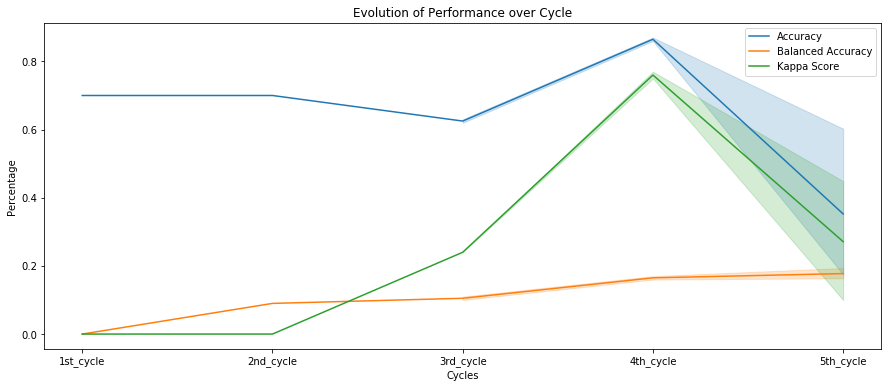

In [103]:
plt.figure(figsize=(15,6))

# formated metrics
performance['acc'] = performance['acc'].apply(lambda x: str(x)[0:4]).astype(float)

performance['balanced_acc'] = performance['balanced_acc'].apply(lambda x: str(x)[0:4]).astype(float)

performance['kappa_score'] = performance['kappa_score'].apply(lambda x: str(x)[0:4]).astype(float)


# Evolution of Performance over Cycles
sns.lineplot(x='cycle', y='acc', data=performance)

sns.lineplot(x='cycle', y='balanced_acc', data=performance)

sns.lineplot(x='cycle', y='kappa_score', data=performance)

# set legend and titles
plt.legend(labels=['Accuracy','Balanced Accuracy', 'Kappa Score'])
plt.title('Evolution of Performance over Cycle')
plt.ylabel('Percentage')
plt.xlabel('Cycles');

In [104]:
performance

,cycle,process,model,acc,balanced_acc,kappa_score
0,1st_cycle,validation_pipeline,Neural Network Model,0.70,0.00,0.00
2,2nd_cycle,baseline_model,Neural Network Model,0.70,0.09,0.00
4,3rd_cycle,replace_na,Neural Network Model,0.62,0.10,0.24
5,3rd_cycle,replace_na,Neural Network Model - CV,0.63,0.11,0.24
7,4th_cycle,feature_engineering,Neural Network Model,0.86,0.16,0.75
8,4th_cycle,feature_engineering,Neural Network Model - CV,0.87,0.17,0.77
10,5th_cycle,balanced_dataset,NN Model - Imbalanced Data,0.87,0.16,0.76
11,5th_cycle,balanced_dataset,NN Model - Imbalanced Data - CV,0.87,0.17,0.77
12,5th_cycle,balanced_dataset,NN Model - Random Undersampling,0.15,0.16,0.07
13,5th_cycle,balanced_dataset,NN Model - Random Undersampling - CV,0.17,0.17,0.10
